In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)
import numpy as np
import math
import torch_geometric
import pandas as pd
import geopandas as gpd
import momepy

import networkx as nx
import networkx.algorithms.community as nx_comm
from sklearn.cluster import KMeans

from utils.load_data import load_city_cluster_df, load_gva_df, load_deprivation_df
from utils.load_geodata import load_gdf, load_graph
from utils.constants import project_root, dataset_root
from utils.constants import rank_fields, log_fields, all_feature_fields, included_places

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Wed May 25 23:19:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 33%   48C    P2    68W / 250W |   7991MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Construction

In [2]:
# training_places = ['Coventry'] # for testing
training_places = ['Leeds', 'Cambridge', 'Coventry', 'Bristol', 'Leicester', 'Glasgow']
# training_places = [full_dataset_label]
test_places = ['Leeds', 'Manchester', 'Sheffield', 'Liverpool', 'Edinburgh', 'Wales']
true_inductive = ['nashville indiana', 'belfast', 'manhattan', 'singapore', 'tokyo']


# Projection
from pyproj import CRS, Transformer
crs_proj = CRS.from_epsg(27700)
crs_4326 = CRS("WGS84")
transformer = Transformer.from_crs(crs_4326, crs_proj)

def proj_and_reorder_bounds(bbox):
  S, W, N, E = bbox
  [S, N], [W, E] = transformer.transform([S, N], [W, E])
  return (S, W, N, E)


In [3]:
from shapely.geometry import LineString

# Data processing parameters
radii = { # metres
    '2km': 2000,
    '10km': 10000,
    '100km': 100000
}
radius = '2km' # for larger radii either turn off boundary masking or widen bbox
modifier = 'rank'
geoms = 2
classes = 0

def add_boundary_mask(gdf, place, rad, verbose=False):
    """Add flag column to indicate geometries within 'rad' of the bounding box
       No masking if loading full dataset"""
    if place == full_dataset_label:
        s = True
        masked_count = 0
    else:
        if place in bboxes:
            # Use defined boundaries
            S, W, N, E = proj_and_reorder_bounds(bboxes[place])
        else:
            # Use total bounds (For osmnx-loaded graphs)
            W, S, E, N = gdf.geometry.total_bounds
        boundary_line = LineString([(S, W), (N, W), (N, E), (S, E), (S, W)])
        boundary = boundary_line.buffer(radii[rad])
        s = gdf.geometry.disjoint(boundary)
        masked_count = gdf.size - s.sum()
    if verbose:
        print(f'Masking {masked_count} out of {gdf.size} geometries within boundary buffer')
    gdf['boundary_mask'] = s


# Construct SSx Graph dataset

In [ ]:
import os
import os.path as osp
from itertools import chain
from virtual_node import VirtualNode
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import OneHotDegree, NormalizeFeatures
from torch_geometric.data import Batch, InMemoryDataset, download_url, extract_zip

# For one hot encoding of node degrees
max_deg = 16

def process_graph(g, feature_fields=[]):
    node_fields = set(chain.from_iterable(d.keys() for *_, d in g.nodes(data=True)))
    to_delete_fields = [field for field in node_fields if field not in feature_fields]
    for _, d in g.nodes(data=True):
        # remove non float-attributes
        for attr in to_delete_fields:
            del d[attr]
    return g

def print_graph_properties(g):
    # Gather some statistics about the graph.
    print(f'Number of nodes: {g.num_nodes}')
    print(f'Number of edges: {g.num_edges}')
    print(f'Average node degree: {g.num_edges / g.num_nodes:.2f}')
    print(f'Number of training nodes: {g.train_mask.sum()}')
    print(f'Training node label rate: {int(g.train_mask.sum()) / g.num_nodes:.2f}')
    print(f'Has isolated nodes: {g.has_isolated_nodes()}')
    print(f'Has self-loops: {g.has_self_loops()}')
    print(f'Is undirected: {g.is_undirected()}')

def load_graphs(df, la_col_name, virtual_node=False,
                feature_fields=[], target_attrs=[]):
    print('Test')
    data_list = []
    la_names = df[la_col_name].unique()
    for place in included_places:
        if place in la_names:
            g = load_graph(place, feature_fields, verbose=True)
            
            # Normalize node features
            g = NormalizeFeatures()(g)
            
            # Add virtual node
            if virtual_node:
                g = VirtualNode()(g)
            
            # One hot encode degree if no node features
            if g.num_node_features == 0:
                g = OneHotDegree(max_deg)(g)
            
            # Get row corresponding to place
            row = df.query(f'`{la_col_name}` == "{place}"')

            # Obtain target attribute(s)
            ys = []
            for target in target_attrs:
                ys.append(row.iloc[0][target])
            
            # Set graph target attribute
            g.y = torch.tensor([ys])
            data_list.append(g)
    return data_list


In [ ]:
def construct_ssx_dataset(places, **kwargs):
    dataset = [ load_graph(place, reset=True, **kwargs) for place in places ]
    return dataset

for agg in [
    'std',
    'median'
]:
    dataset = construct_ssx_dataset(included_places, 
                                    feature_fields=all_feature_fields, 
                                    approach='primal', 
                                    clean='False', 
                                    agg=agg, 
                                    verbose=True)
    for data in dataset:
        data.node_attrs = list(data.node_attrs)
    torch.save(dataset, f'{dataset_root}/ssx_dataset_{agg}.pt')

/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


69680 geometries retrieved from Caerphilly
Generated graph with 2550 nodes and 3363 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Ribble Valley with key ('Ribble Valley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Ribble Valley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


27220 geometries retrieved from Ribble Valley
Generated graph with 1013 nodes and 1329 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of The Vale of Glamorgan with key ('The Vale of Glamorgan', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading The Vale of Glamorgan from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


55220 geometries retrieved from The Vale of Glamorgan
Generated graph with 1972 nodes and 2701 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bridgend with key ('Bridgend', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bridgend from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


52900 geometries retrieved from Bridgend
Generated graph with 1918 nodes and 2529 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Neath Port Talbot with key ('Neath Port Talbot', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Neath Port Talbot from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


58520 geometries retrieved from Neath Port Talbot
Generated graph with 2155 nodes and 2852 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Merthyr Tydfil with key ('Merthyr Tydfil', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Merthyr Tydfil from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


26100 geometries retrieved from Merthyr Tydfil
Generated graph with 954 nodes and 1260 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Swansea with key ('Swansea', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Swansea from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


81300 geometries retrieved from Swansea
Generated graph with 2960 nodes and 3979 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cardiff with key ('Cardiff', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cardiff from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


95220 geometries retrieved from Cardiff
Generated graph with 3363 nodes and 4637 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Blaenau Gwent with key ('Blaenau Gwent', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Blaenau Gwent from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33240 geometries retrieved from Blaenau Gwent
Generated graph with 1162 nodes and 1620 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Newport with key ('Newport', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Newport from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48020 geometries retrieved from Newport
Generated graph with 1744 nodes and 2323 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hyndburn with key ('Hyndburn', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hyndburn from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40220 geometries retrieved from Hyndburn
Generated graph with 1350 nodes and 1959 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Torfaen with key ('Torfaen', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Torfaen from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33840 geometries retrieved from Torfaen
Generated graph with 1232 nodes and 1626 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Hertfordshire with key ('East Hertfordshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Hertfordshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43820 geometries retrieved from East Hertfordshire
Generated graph with 1682 nodes and 2120 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Stevenage with key ('Stevenage', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Stevenage from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


18400 geometries retrieved from Stevenage
Generated graph with 678 nodes and 881 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Uttlesford with key ('Uttlesford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Uttlesford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37580 geometries retrieved from Uttlesford
Generated graph with 1479 nodes and 1828 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of St Albans with key ('St Albans', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading St Albans from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


44540 geometries retrieved from St Albans
Generated graph with 1606 nodes and 2155 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Lindsey with key ('East Lindsey', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Lindsey from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


74060 geometries retrieved from East Lindsey
Generated graph with 2752 nodes and 3630 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Colchester with key ('Colchester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Colchester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


52160 geometries retrieved from Colchester
Generated graph with 1935 nodes and 2520 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Northamptonshire with key ('East Northamptonshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Northamptonshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28700 geometries retrieved from East Northamptonshire
Generated graph with 1058 nodes and 1400 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Central Bedfordshire with key ('Central Bedfordshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Central Bedfordshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


67240 geometries retrieved from Central Bedfordshire
Generated graph with 2571 nodes and 3247 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Babergh with key ('Babergh', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Babergh from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40500 geometries retrieved from Babergh
Generated graph with 1556 nodes and 1976 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Braintree with key ('Braintree', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Braintree from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


51520 geometries retrieved from Braintree
Generated graph with 1977 nodes and 2510 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Huntingdonshire with key ('Huntingdonshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Huntingdonshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


55580 geometries retrieved from Huntingdonshire
Generated graph with 2163 nodes and 2696 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Suffolk Coastal with key ('Suffolk Coastal', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Suffolk Coastal from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


64000 geometries retrieved from Suffolk Coastal
Generated graph with 2363 nodes and 3147 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Ipswich with key ('Ipswich', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Ipswich from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


41020 geometries retrieved from Ipswich
Generated graph with 1417 nodes and 2012 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Peterborough with key ('Peterborough', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Peterborough from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


53760 geometries retrieved from Peterborough
Generated graph with 2016 nodes and 2619 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Holland with key ('South Holland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Holland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


44880 geometries retrieved from South Holland
Generated graph with 1666 nodes and 2207 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Welwyn Hatfield with key ('Welwyn Hatfield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Welwyn Hatfield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32660 geometries retrieved from Welwyn Hatfield
Generated graph with 1172 nodes and 1555 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Boston with key ('Boston', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Boston from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33020 geometries retrieved from Boston
Generated graph with 1213 nodes and 1617 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Watford with key ('Watford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Watford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


20420 geometries retrieved from Watford
Generated graph with 711 nodes and 977 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Maldon with key ('Maldon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Maldon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


22080 geometries retrieved from Maldon
Generated graph with 855 nodes and 1075 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Cambridgeshire with key ('South Cambridgeshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Cambridgeshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47400 geometries retrieved from South Cambridgeshire
Generated graph with 1870 nodes and 2289 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hertsmere with key ('Hertsmere', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hertsmere from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28540 geometries retrieved from Hertsmere
Generated graph with 1015 nodes and 1389 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Three Rivers with key ('Three Rivers', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Three Rivers from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


25740 geometries retrieved from Three Rivers
Generated graph with 926 nodes and 1214 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bedford with key ('Bedford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bedford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


46860 geometries retrieved from Bedford
Generated graph with 1727 nodes and 2257 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Brentwood with key ('Brentwood', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Brentwood from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


24440 geometries retrieved from Brentwood
Generated graph with 912 nodes and 1189 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Hertfordshire with key ('North Hertfordshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Hertfordshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


41140 geometries retrieved from North Hertfordshire
Generated graph with 1460 nodes and 1921 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cambridge with key ('Cambridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cambridge from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


25020 geometries retrieved from Cambridge
Generated graph with 906 nodes and 1181 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Basildon with key ('Basildon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Basildon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


39400 geometries retrieved from Basildon
Generated graph with 1521 nodes and 1915 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Harlow with key ('Harlow', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Harlow from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


19920 geometries retrieved from Harlow
Generated graph with 742 nodes and 948 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Chelmsford with key ('Chelmsford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Chelmsford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49260 geometries retrieved from Chelmsford
Generated graph with 1855 nodes and 2389 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tendring with key ('Tendring', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tendring from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54440 geometries retrieved from Tendring
Generated graph with 1945 nodes and 2661 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Dacorum with key ('Dacorum', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Dacorum from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43580 geometries retrieved from Dacorum
Generated graph with 1584 nodes and 2120 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Luton with key ('Luton', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Luton from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


41260 geometries retrieved from Luton
Generated graph with 1440 nodes and 2018 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Harrow with key ('Harrow', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Harrow from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48980 geometries retrieved from Harrow
Generated graph with 1649 nodes and 2319 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Havering with key ('Havering', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Havering from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


56100 geometries retrieved from Havering
Generated graph with 1967 nodes and 2745 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Islington with key ('Islington', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Islington from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37560 geometries retrieved from Islington
Generated graph with 1256 nodes and 1832 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Brent with key ('Brent', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Brent from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


53460 geometries retrieved from Brent
Generated graph with 1810 nodes and 2582 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Greenwich with key ('Greenwich', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Greenwich from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


56500 geometries retrieved from Greenwich
Generated graph with 1894 nodes and 2717 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Castle Point with key ('Castle Point', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Castle Point from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


27220 geometries retrieved from Castle Point
Generated graph with 966 nodes and 1326 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Aylesbury Vale with key ('Aylesbury Vale', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Aylesbury Vale from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54800 geometries retrieved from Aylesbury Vale
Generated graph with 2082 nodes and 2645 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Milton Keynes with key ('Milton Keynes', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Milton Keynes from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


75880 geometries retrieved from Milton Keynes
Generated graph with 2710 nodes and 3692 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Kettering with key ('Kettering', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Kettering from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32120 geometries retrieved from Kettering
Generated graph with 1087 nodes and 1510 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Thurrock with key ('Thurrock', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Thurrock from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


39060 geometries retrieved from Thurrock
Generated graph with 1417 nodes and 1881 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Westminster with key ('Westminster', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Westminster from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


64020 geometries retrieved from Westminster
Generated graph with 1975 nodes and 3095 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Camden with key ('Camden', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Camden from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43840 geometries retrieved from Camden
Generated graph with 1447 nodes and 2136 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hammersmith and Fulham with key ('Hammersmith and Fulham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hammersmith and Fulham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34220 geometries retrieved from Hammersmith and Fulham
Generated graph with 1142 nodes and 1674 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Kensington and Chelsea with key ('Kensington and Chelsea', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Kensington and Chelsea from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


36560 geometries retrieved from Kensington and Chelsea
Generated graph with 1172 nodes and 1787 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Teignbridge with key ('Teignbridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Teignbridge from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


77920 geometries retrieved from Teignbridge
Generated graph with 2832 nodes and 3840 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Southend-on-Sea with key ('Southend-on-Sea', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Southend-on-Sea from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48700 geometries retrieved from Southend-on-Sea
Generated graph with 1608 nodes and 2395 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hart with key ('Hart', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hart from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32080 geometries retrieved from Hart
Generated graph with 1192 nodes and 1550 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Hampshire with key ('East Hampshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Hampshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


50180 geometries retrieved from East Hampshire
Generated graph with 1885 nodes and 2436 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Lewisham with key ('Lewisham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Lewisham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54200 geometries retrieved from Lewisham
Generated graph with 1812 nodes and 2631 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rochford with key ('Rochford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rochford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


21420 geometries retrieved from Rochford
Generated graph with 829 nodes and 1036 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wandsworth with key ('Wandsworth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wandsworth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


59360 geometries retrieved from Wandsworth
Generated graph with 1949 nodes and 2904 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North East Lincolnshire with key ('North East Lincolnshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North East Lincolnshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49080 geometries retrieved from North East Lincolnshire
Generated graph with 1710 nodes and 2387 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wokingham with key ('Wokingham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wokingham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


41100 geometries retrieved from Wokingham
Generated graph with 1567 nodes and 1962 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Barking and Dagenham with key ('Barking and Dagenham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Barking and Dagenham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37460 geometries retrieved from Barking and Dagenham
Generated graph with 1263 nodes and 1822 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Newham with key ('Newham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Newham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


51060 geometries retrieved from Newham
Generated graph with 1695 nodes and 2497 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Portsmouth with key ('Portsmouth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Portsmouth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


56220 geometries retrieved from Portsmouth
Generated graph with 1890 nodes and 2758 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tower Hamlets with key ('Tower Hamlets', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tower Hamlets from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43880 geometries retrieved from Tower Hamlets
Generated graph with 1483 nodes and 2140 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Daventry with key ('Daventry', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Daventry from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33700 geometries retrieved from Daventry
Generated graph with 1242 nodes and 1638 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Corby with key ('Corby', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Corby from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


20100 geometries retrieved from Corby
Generated graph with 748 nodes and 974 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rushmoor with key ('Rushmoor', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rushmoor from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


23900 geometries retrieved from Rushmoor
Generated graph with 859 nodes and 1155 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Northamptonshire with key ('South Northamptonshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Northamptonshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33720 geometries retrieved from South Northamptonshire
Generated graph with 1276 nodes and 1638 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wellingborough with key ('Wellingborough', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wellingborough from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


22560 geometries retrieved from Wellingborough
Generated graph with 801 nodes and 1099 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hackney with key ('Hackney', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hackney from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40280 geometries retrieved from Hackney
Generated graph with 1347 nodes and 1977 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Torbay with key ('Torbay', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Torbay from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49360 geometries retrieved from Torbay
Generated graph with 1724 nodes and 2416 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Northampton with key ('Northampton', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Northampton from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


57560 geometries retrieved from Northampton
Generated graph with 2048 nodes and 2790 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Havant with key ('Havant', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Havant from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33980 geometries retrieved from Havant
Generated graph with 1241 nodes and 1644 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Reading with key ('Reading', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Reading from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


35040 geometries retrieved from Reading
Generated graph with 1249 nodes and 1691 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Swale with key ('Swale', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Swale from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48280 geometries retrieved from Swale
Generated graph with 1766 nodes and 2351 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Shepway with key ('Shepway', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Shepway from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


44500 geometries retrieved from Shepway
Generated graph with 1603 nodes and 2154 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hastings with key ('Hastings', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hastings from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


23940 geometries retrieved from Hastings
Generated graph with 852 nodes and 1170 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bromley with key ('Bromley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bromley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


75680 geometries retrieved from Bromley
Generated graph with 2640 nodes and 3662 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tunbridge Wells with key ('Tunbridge Wells', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tunbridge Wells from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37980 geometries retrieved from Tunbridge Wells
Generated graph with 1401 nodes and 1851 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Maidstone with key ('Maidstone', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Maidstone from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


50860 geometries retrieved from Maidstone
Generated graph with 1881 nodes and 2466 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cherwell with key ('Cherwell', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cherwell from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48740 geometries retrieved from Cherwell
Generated graph with 1821 nodes and 2363 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Oadby and Wigston with key ('Oadby and Wigston', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Oadby and Wigston from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


16620 geometries retrieved from Oadby and Wigston
Generated graph with 601 nodes and 798 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rother with key ('Rother', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rother from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34400 geometries retrieved from Rother
Generated graph with 1298 nodes and 1673 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Canterbury with key ('Canterbury', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Canterbury from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47780 geometries retrieved from Canterbury
Generated graph with 1710 nodes and 2325 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Ashford with key ('Ashford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Ashford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


45080 geometries retrieved from Ashford
Generated graph with 1696 nodes and 2199 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Thanet with key ('Thanet', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Thanet from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49220 geometries retrieved from Thanet
Generated graph with 1679 nodes and 2408 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Dover with key ('Dover', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Dover from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


44900 geometries retrieved from Dover
Generated graph with 1587 nodes and 2186 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Nuneaton and Bedworth with key ('Nuneaton and Bedworth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Nuneaton and Bedworth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


30740 geometries retrieved from Nuneaton and Bedworth
Generated graph with 1116 nodes and 1468 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Isle of Wight with key ('Isle of Wight', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Isle of Wight from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54160 geometries retrieved from Isle of Wight
Generated graph with 1940 nodes and 2637 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wycombe with key ('Wycombe', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wycombe from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47020 geometries retrieved from Wycombe
Generated graph with 1741 nodes and 2263 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Enfield with key ('Enfield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Enfield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


66340 geometries retrieved from Enfield
Generated graph with 2299 nodes and 3232 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Slough with key ('Slough', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Slough from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


27420 geometries retrieved from Slough
Generated graph with 988 nodes and 1319 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Bucks with key ('South Bucks', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Bucks from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


25460 geometries retrieved from South Bucks
Generated graph with 946 nodes and 1219 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hillingdon with key ('Hillingdon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hillingdon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


66740 geometries retrieved from Hillingdon
Generated graph with 2363 nodes and 3216 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Ealing with key ('Ealing', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Ealing from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


68380 geometries retrieved from Ealing
Generated graph with 2319 nodes and 3316 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Chiltern with key ('Chiltern', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Chiltern from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28280 geometries retrieved from Chiltern
Generated graph with 1049 nodes and 1351 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Copeland with key ('Copeland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Copeland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


36640 geometries retrieved from Copeland
Generated graph with 1370 nodes and 1777 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Windsor and Maidenhead with key ('Windsor and Maidenhead', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Windsor and Maidenhead from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43420 geometries retrieved from Windsor and Maidenhead
Generated graph with 1401 nodes and 1825 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Plymouth with key ('Plymouth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Plymouth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


79640 geometries retrieved from Plymouth
Generated graph with 2813 nodes and 3856 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Hams with key ('South Hams', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Hams from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


81060 geometries retrieved from South Hams
Generated graph with 2883 nodes and 3895 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Oxford with key ('Oxford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Oxford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34300 geometries retrieved from Oxford
Generated graph with 1195 nodes and 1666 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Waltham Forest with key ('Waltham Forest', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Waltham Forest from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54060 geometries retrieved from Waltham Forest
Generated graph with 1824 nodes and 2645 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Mendip with key ('Mendip', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Mendip from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


63860 geometries retrieved from Mendip
Generated graph with 2338 nodes and 3128 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Dudley with key ('Dudley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Dudley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


94240 geometries retrieved from Dudley
Generated graph with 3321 nodes and 4574 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cotswold with key ('Cotswold', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cotswold from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


56500 geometries retrieved from Cotswold
Generated graph with 2100 nodes and 2765 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Erewash with key ('Erewash', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Erewash from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


31440 geometries retrieved from Erewash
Generated graph with 1137 nodes and 1541 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Redbridge with key ('Redbridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Redbridge from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


64140 geometries retrieved from Redbridge
Generated graph with 2137 nodes and 3159 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Epping Forest with key ('Epping Forest', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Epping Forest from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


39560 geometries retrieved from Epping Forest
Generated graph with 1487 nodes and 1900 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Test Valley with key ('Test Valley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Test Valley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


46420 geometries retrieved from Test Valley
Generated graph with 1752 nodes and 2254 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Basingstoke and Deane with key ('Basingstoke and Deane', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Basingstoke and Deane from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54460 geometries retrieved from Basingstoke and Deane
Generated graph with 2061 nodes and 2645 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Gloucestershire with key ('South Gloucestershire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Gloucestershire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


84060 geometries retrieved from South Gloucestershire
Generated graph with 3156 nodes and 4126 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Woking with key ('Woking', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Woking from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


23740 geometries retrieved from Woking
Generated graph with 888 nodes and 1143 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Broxbourne with key ('Broxbourne', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Broxbourne from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


19460 geometries retrieved from Broxbourne
Generated graph with 736 nodes and 936 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wolverhampton with key ('Wolverhampton', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wolverhampton from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


72740 geometries retrieved from Wolverhampton
Generated graph with 2522 nodes and 3518 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wiltshire with key ('Wiltshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wiltshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


192060 geometries retrieved from Wiltshire
Generated graph with 7202 nodes and 9314 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Swindon with key ('Swindon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Swindon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


58040 geometries retrieved from Swindon
Generated graph with 2147 nodes and 2799 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bath and North East Somerset with key ('Bath and North East Somerset', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bath and North East Somerset from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


60920 geometries retrieved from Bath and North East Somerset
Generated graph with 2234 nodes and 2968 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Trafford with key ('Trafford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Trafford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


77180 geometries retrieved from Trafford
Generated graph with 2644 nodes and 3738 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Salford with key ('Salford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Salford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


82460 geometries retrieved from Salford
Generated graph with 2850 nodes and 4003 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Staffordshire with key ('South Staffordshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Staffordshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


41620 geometries retrieved from South Staffordshire
Generated graph with 1527 nodes and 2000 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Oxfordshire with key ('West Oxfordshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Oxfordshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


44040 geometries retrieved from West Oxfordshire
Generated graph with 1624 nodes and 2139 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Malvern Hills with key ('Malvern Hills', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Malvern Hills from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40500 geometries retrieved from Malvern Hills
Generated graph with 1563 nodes and 1976 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Vale of White Horse with key ('Vale of White Horse', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Vale of White Horse from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


38780 geometries retrieved from Vale of White Horse
Generated graph with 1461 nodes and 1838 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Kesteven with key ('South Kesteven', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Kesteven from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


50000 geometries retrieved from South Kesteven
Generated graph with 1842 nodes and 2435 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Kesteven with key ('North Kesteven', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Kesteven from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43260 geometries retrieved from North Kesteven
Generated graph with 1631 nodes and 2106 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Guildford with key ('Guildford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Guildford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


45140 geometries retrieved from Guildford
Generated graph with 1715 nodes and 2168 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Southwark with key ('Southwark', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Southwark from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


51060 geometries retrieved from Southwark
Generated graph with 1713 nodes and 2487 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Chichester with key ('Chichester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Chichester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47900 geometries retrieved from Chichester
Generated graph with 1827 nodes and 2346 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Waverley with key ('Waverley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Waverley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43320 geometries retrieved from Waverley
Generated graph with 1652 nodes and 2109 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Elmbridge with key ('Elmbridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Elmbridge from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34560 geometries retrieved from Elmbridge
Generated graph with 1264 nodes and 1651 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Forest of Dean with key ('Forest of Dean', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Forest of Dean from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


51900 geometries retrieved from Forest of Dean
Generated graph with 1953 nodes and 2537 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tewkesbury with key ('Tewkesbury', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tewkesbury from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34320 geometries retrieved from Tewkesbury
Generated graph with 1279 nodes and 1577 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Charnwood with key ('Charnwood', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Charnwood from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49040 geometries retrieved from Charnwood
Generated graph with 1799 nodes and 2379 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Sheffield with key ('Sheffield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Sheffield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


192860 geometries retrieved from Sheffield
Generated graph with 6556 nodes and 9399 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Ashfield with key ('Ashfield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Ashfield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


35420 geometries retrieved from Ashfield
Generated graph with 1015 nodes and 1315 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North West Leicestershire with key ('North West Leicestershire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North West Leicestershire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33680 geometries retrieved from North West Leicestershire
Generated graph with 1241 nodes and 1617 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North East Derbyshire with key ('North East Derbyshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North East Derbyshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


39780 geometries retrieved from North East Derbyshire
Generated graph with 1368 nodes and 1803 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Stroud with key ('Stroud', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Stroud from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


53260 geometries retrieved from Stroud
Generated graph with 1978 nodes and 2579 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Shropshire with key ('Shropshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Shropshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


175280 geometries retrieved from Shropshire
Generated graph with 6461 nodes and 8566 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Telford and Wrekin with key ('Telford and Wrekin', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Telford and Wrekin from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


58640 geometries retrieved from Telford and Wrekin
Generated graph with 2236 nodes and 2836 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Horsham with key ('Horsham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Horsham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37260 geometries retrieved from Horsham
Generated graph with 1426 nodes and 1799 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of City of London with key ('City of London', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading City of London from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


10960 geometries retrieved from City of London
Generated graph with 370 nodes and 536 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Newcastle-under-Lyme with key ('Newcastle-under-Lyme', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Newcastle-under-Lyme from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


46520 geometries retrieved from Newcastle-under-Lyme
Generated graph with 1661 nodes and 2235 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Stafford with key ('Stafford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Stafford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


57560 geometries retrieved from Stafford
Generated graph with 2118 nodes and 2777 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Stoke-on-Trent with key ('Stoke-on-Trent', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Stoke-on-Trent from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


94640 geometries retrieved from Stoke-on-Trent
Generated graph with 3235 nodes and 4572 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Arun with key ('Arun', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Arun from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43180 geometries retrieved from Arun
Generated graph with 1562 nodes and 2099 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Lichfield with key ('Lichfield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Lichfield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37580 geometries retrieved from Lichfield
Generated graph with 1381 nodes and 1819 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Sandwell with key ('Sandwell', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Sandwell from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


89760 geometries retrieved from Sandwell
Generated graph with 3048 nodes and 4347 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Birmingham with key ('Birmingham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Birmingham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


230820 geometries retrieved from Birmingham
Generated graph with 7829 nodes and 11246 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Amber Valley with key ('Amber Valley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Amber Valley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


38960 geometries retrieved from Amber Valley
Generated graph with 1442 nodes and 1892 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Mole Valley with key ('Mole Valley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Mole Valley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


29380 geometries retrieved from Mole Valley
Generated graph with 1128 nodes and 1411 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bolsover with key ('Bolsover', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bolsover from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28120 geometries retrieved from Bolsover
Generated graph with 1026 nodes and 1359 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rushcliffe with key ('Rushcliffe', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rushcliffe from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40000 geometries retrieved from Rushcliffe
Generated graph with 1477 nodes and 1946 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wychavon with key ('Wychavon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wychavon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47780 geometries retrieved from Wychavon
Generated graph with 1840 nodes and 2329 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Gedling with key ('Gedling', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Gedling from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34480 geometries retrieved from Gedling
Generated graph with 1178 nodes and 1599 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Gloucester with key ('Gloucester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Gloucester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


29140 geometries retrieved from Gloucester
Generated graph with 1095 nodes and 1431 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Liverpool with key ('Liverpool', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Liverpool from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


177000 geometries retrieved from Liverpool
Generated graph with 5882 nodes and 8627 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Newark and Sherwood with key ('Newark and Sherwood', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Newark and Sherwood from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49920 geometries retrieved from Newark and Sherwood
Generated graph with 1871 nodes and 2437 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Sefton with key ('Sefton', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Sefton from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


99260 geometries retrieved from Sefton
Generated graph with 3353 nodes and 4835 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of St. Helens with key ('St. Helens', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading St. Helens from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


69480 geometries retrieved from St. Helens
Generated graph with 2395 nodes and 3369 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Worcester with key ('Worcester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Worcester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


25620 geometries retrieved from Worcester
Generated graph with 932 nodes and 1253 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Flintshire with key ('Flintshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Flintshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


67940 geometries retrieved from Flintshire
Generated graph with 2448 nodes and 3281 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bassetlaw with key ('Bassetlaw', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bassetlaw from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


51360 geometries retrieved from Bassetlaw
Generated graph with 1922 nodes and 2496 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Knowsley with key ('Knowsley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Knowsley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48320 geometries retrieved from Knowsley
Generated graph with 1708 nodes and 2310 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wyre Forest with key ('Wyre Forest', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wyre Forest from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


31100 geometries retrieved from Wyre Forest
Generated graph with 1169 nodes and 1507 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bromsgrove with key ('Bromsgrove', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bromsgrove from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


33960 geometries retrieved from Bromsgrove
Generated graph with 1227 nodes and 1646 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Denbighshire with key ('Denbighshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Denbighshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


63480 geometries retrieved from Denbighshire
Generated graph with 2324 nodes and 3102 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Herefordshire, County of with key ('Herefordshire, County of', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Herefordshire, County of from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


108240 geometries retrieved from Herefordshire, County of
Generated graph with 4082 nodes and 5294 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rotherham with key ('Rotherham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rotherham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


95680 geometries retrieved from Rotherham
Generated graph with 3344 nodes and 4567 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Chesterfield with key ('Chesterfield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Chesterfield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


38580 geometries retrieved from Chesterfield
Generated graph with 1351 nodes and 1849 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Barnet with key ('Barnet', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Barnet from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


78180 geometries retrieved from Barnet
Generated graph with 2676 nodes and 3781 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Monmouthshire with key ('Monmouthshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Monmouthshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


60500 geometries retrieved from Monmouthshire
Generated graph with 2280 nodes and 2967 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cheltenham with key ('Cheltenham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cheltenham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34640 geometries retrieved from Cheltenham
Generated graph with 1221 nodes and 1674 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Spelthorne with key ('Spelthorne', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Spelthorne from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28440 geometries retrieved from Spelthorne
Generated graph with 1008 nodes and 1359 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Sutton with key ('Sutton', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Sutton from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


43920 geometries retrieved from Sutton
Generated graph with 1481 nodes and 2101 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cheshire East with key ('Cheshire East', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cheshire East from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


148060 geometries retrieved from Cheshire East
Generated graph with 5412 nodes and 7190 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cheshire West and Chester with key ('Cheshire West and Chester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cheshire West and Chester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


132180 geometries retrieved from Cheshire West and Chester
Generated graph with 4801 nodes and 6395 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Runnymede with key ('Runnymede', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Runnymede from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


21020 geometries retrieved from Runnymede
Generated graph with 784 nodes and 1011 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Reigate and Banstead with key ('Reigate and Banstead', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Reigate and Banstead from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


39220 geometries retrieved from Reigate and Banstead
Generated graph with 1431 nodes and 1880 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Kingston upon Thames with key ('Kingston upon Thames', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Kingston upon Thames from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34800 geometries retrieved from Kingston upon Thames
Generated graph with 1203 nodes and 1702 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Epsom and Ewell with key ('Epsom and Ewell', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Epsom and Ewell from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


19040 geometries retrieved from Epsom and Ewell
Generated graph with 688 nodes and 929 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tandridge with key ('Tandridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tandridge from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28320 geometries retrieved from Tandridge
Generated graph with 1066 nodes and 1375 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Merton with key ('Merton', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Merton from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


38940 geometries retrieved from Merton
Generated graph with 1369 nodes and 1899 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Croydon with key ('Croydon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Croydon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


79380 geometries retrieved from Croydon
Generated graph with 2722 nodes and 3871 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Stockport with key ('Stockport', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Stockport from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


95480 geometries retrieved from Stockport
Generated graph with 3367 nodes and 4627 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Stratford-on-Avon with key ('Stratford-on-Avon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Stratford-on-Avon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


56940 geometries retrieved from Stratford-on-Avon
Generated graph with 2114 nodes and 2761 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Northumberland with key ('Northumberland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Northumberland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


194600 geometries retrieved from Northumberland
Generated graph with 7252 nodes and 9442 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Walsall with key ('Walsall', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Walsall from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


79420 geometries retrieved from Walsall
Generated graph with 2751 nodes and 3832 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Solihull with key ('Solihull', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Solihull from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


57600 geometries retrieved from Solihull
Generated graph with 2099 nodes and 2782 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Mid Sussex with key ('Mid Sussex', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Mid Sussex from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


36560 geometries retrieved from Mid Sussex
Generated graph with 1380 nodes and 1766 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Waveney with key ('Waveney', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Waveney from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47120 geometries retrieved from Waveney
Generated graph with 1710 nodes and 2304 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Lincoln with key ('Lincoln', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Lincoln from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


25140 geometries retrieved from Lincoln
Generated graph with 906 nodes and 1210 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tonbridge and Malling with key ('Tonbridge and Malling', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tonbridge and Malling from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40180 geometries retrieved from Tonbridge and Malling
Generated graph with 1496 nodes and 1931 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Redditch with key ('Redditch', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Redditch from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


19740 geometries retrieved from Redditch
Generated graph with 788 nodes and 971 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Doncaster with key ('Doncaster', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Doncaster from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


122840 geometries retrieved from Doncaster
Generated graph with 4322 nodes and 5946 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Brighton and Hove with key ('Brighton and Hove', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Brighton and Hove from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


77140 geometries retrieved from Brighton and Hove
Generated graph with 2551 nodes and 3777 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tameside with key ('Tameside', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tameside from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


79580 geometries retrieved from Tameside
Generated graph with 2691 nodes and 3849 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of High Peak with key ('High Peak', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading High Peak from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


35120 geometries retrieved from High Peak
Generated graph with 1305 nodes and 1704 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Lincolnshire with key ('North Lincolnshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Lincolnshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


62380 geometries retrieved from North Lincolnshire
Generated graph with 2256 nodes and 3027 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Lewes with key ('Lewes', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Lewes from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


36760 geometries retrieved from Lewes
Generated graph with 1355 nodes and 1789 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Warwickshire with key ('North Warwickshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Warwickshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28580 geometries retrieved from North Warwickshire
Generated graph with 1047 nodes and 1366 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Gravesham with key ('Gravesham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Gravesham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


29980 geometries retrieved from Gravesham
Generated graph with 1062 nodes and 1454 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Riding of Yorkshire with key ('East Riding of Yorkshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Riding of Yorkshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


133580 geometries retrieved from East Riding of Yorkshire
Generated graph with 4964 nodes and 6489 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Somerset with key ('South Somerset', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Somerset from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


89080 geometries retrieved from South Somerset
Generated graph with 3321 nodes and 4374 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Dorset with key ('West Dorset', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Dorset from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


63320 geometries retrieved from West Dorset
Generated graph with 2384 nodes and 3071 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Sevenoaks with key ('Sevenoaks', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Sevenoaks from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


39200 geometries retrieved from Sevenoaks
Generated graph with 1461 nodes and 1903 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Medway with key ('Medway', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Medway from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


68440 geometries retrieved from Medway
Generated graph with 2461 nodes and 3322 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Nottingham with key ('Nottingham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Nottingham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


83340 geometries retrieved from Nottingham
Generated graph with 2834 nodes and 4056 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Tamworth with key ('Tamworth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Tamworth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


16700 geometries retrieved from Tamworth
Generated graph with 652 nodes and 807 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Warwick with key ('Warwick', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Warwick from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47200 geometries retrieved from Warwick
Generated graph with 1665 nodes and 2281 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Dartford with key ('Dartford', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Dartford from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


25320 geometries retrieved from Dartford
Generated graph with 913 nodes and 1227 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Surrey Heath with key ('Surrey Heath', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Surrey Heath from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


26720 geometries retrieved from Surrey Heath
Generated graph with 1006 nodes and 1294 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Norfolk with key ('South Norfolk', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Norfolk from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


71100 geometries retrieved from South Norfolk
Generated graph with 2623 nodes and 3490 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Oldham with key ('Oldham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Oldham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


89120 geometries retrieved from Oldham
Generated graph with 3009 nodes and 4313 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Lindsey with key ('West Lindsey', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Lindsey from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


44320 geometries retrieved from West Lindsey
Generated graph with 1651 nodes and 2164 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Lambeth with key ('Lambeth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Lambeth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54740 geometries retrieved from Lambeth
Generated graph with 1816 nodes and 2675 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Norfolk with key ('North Norfolk', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Norfolk from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


75220 geometries retrieved from North Norfolk
Generated graph with 2717 nodes and 3691 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Breckland with key ('Breckland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Breckland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


68960 geometries retrieved from Breckland
Generated graph with 2556 nodes and 3376 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Broxtowe with key ('Broxtowe', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Broxtowe from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32220 geometries retrieved from Broxtowe
Generated graph with 1162 nodes and 1541 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Staffordshire Moorlands with key ('Staffordshire Moorlands', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Staffordshire Moorlands from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


47280 geometries retrieved from Staffordshire Moorlands
Generated graph with 1722 nodes and 2300 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Worthing with key ('Worthing', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Worthing from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32060 geometries retrieved from Worthing
Generated graph with 1080 nodes and 1572 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of King's Lynn and West Norfolk with key ("King's Lynn and West Norfolk", "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading King's Lynn and West Norfolk from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


76620 geometries retrieved from King's Lynn and West Norfolk
Generated graph with 2862 nodes and 3757 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Kirklees with key ('Kirklees', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Kirklees from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


158000 geometries retrieved from Kirklees
Generated graph with 5504 nodes and 7670 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Calderdale with key ('Calderdale', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Calderdale from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


100620 geometries retrieved from Calderdale
Generated graph with 3521 nodes and 4866 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Great Yarmouth with key ('Great Yarmouth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Great Yarmouth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


42820 geometries retrieved from Great Yarmouth
Generated graph with 1496 nodes and 2105 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Crawley with key ('Crawley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Crawley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


23980 geometries retrieved from Crawley
Generated graph with 878 nodes and 1161 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Devon with key ('East Devon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Devon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


90300 geometries retrieved from East Devon
Generated graph with 3247 nodes and 4393 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Mid Devon with key ('Mid Devon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Mid Devon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


62980 geometries retrieved from Mid Devon
Generated graph with 2349 nodes and 3096 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of St Edmundsbury with key ('St Edmundsbury', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading St Edmundsbury from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


41540 geometries retrieved from St Edmundsbury
Generated graph with 1573 nodes and 2024 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Mid Suffolk with key ('Mid Suffolk', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Mid Suffolk from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


50020 geometries retrieved from Mid Suffolk
Generated graph with 1903 nodes and 2457 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of East Cambridgeshire with key ('East Cambridgeshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading East Cambridgeshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


29120 geometries retrieved from East Cambridgeshire
Generated graph with 1155 nodes and 1425 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Forest Heath with key ('Forest Heath', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Forest Heath from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


19980 geometries retrieved from Forest Heath
Generated graph with 591 nodes and 718 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Devon with key ('North Devon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Devon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


71540 geometries retrieved from North Devon
Generated graph with 2659 nodes and 3486 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Fenland with key ('Fenland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Fenland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32760 geometries retrieved from Fenland
Generated graph with 1257 nodes and 1588 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Dorset with key ('North Dorset', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Dorset from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34200 geometries retrieved from North Dorset
Generated graph with 1304 nodes and 1650 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bracknell Forest with key ('Bracknell Forest', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bracknell Forest from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


24580 geometries retrieved from Bracknell Forest
Generated graph with 973 nodes and 1202 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Haringey with key ('Haringey', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Haringey from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


46420 geometries retrieved from Haringey
Generated graph with 1559 nodes and 2276 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Coventry with key ('Coventry', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Coventry from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


76800 geometries retrieved from Coventry
Generated graph with 2633 nodes and 3731 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hounslow with key ('Hounslow', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hounslow from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


50240 geometries retrieved from Hounslow
Generated graph with 1747 nodes and 2417 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wakefield with key ('Wakefield', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wakefield from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


117960 geometries retrieved from Wakefield
Generated graph with 4223 nodes and 5647 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Eastbourne with key ('Eastbourne', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Eastbourne from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


30080 geometries retrieved from Eastbourne
Generated graph with 1014 nodes and 1461 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Selby with key ('Selby', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Selby from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


37320 geometries retrieved from Selby
Generated graph with 1419 nodes and 1816 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wealden with key ('Wealden', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wealden from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


57900 geometries retrieved from Wealden
Generated graph with 2177 nodes and 2845 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Somerset with key ('West Somerset', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Somerset from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


29740 geometries retrieved from West Somerset
Generated graph with 1130 nodes and 1457 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Exeter with key ('Exeter', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Exeter from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


32720 geometries retrieved from Exeter
Generated graph with 1169 nodes and 1579 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Kingston upon Hull, City of with key ('Kingston upon Hull, City of', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Kingston upon Hull, City of from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


65280 geometries retrieved from Kingston upon Hull, City of
Generated graph with 2306 nodes and 3156 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Broadland with key ('Broadland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Broadland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


54540 geometries retrieved from Broadland
Generated graph with 2039 nodes and 2657 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Norwich with key ('Norwich', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Norwich from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


40280 geometries retrieved from Norwich
Generated graph with 1361 nodes and 1889 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Eden with key ('Eden', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Eden from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


56000 geometries retrieved from Eden
Generated graph with 2098 nodes and 2742 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rugby with key ('Rugby', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rugby from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


34260 geometries retrieved from Rugby
Generated graph with 1241 nodes and 1658 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Barrow-in-Furness with key ('Barrow-in-Furness', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Barrow-in-Furness from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


36280 geometries retrieved from Barrow-in-Furness
Generated graph with 1209 nodes and 1777 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Cannock Chase with key ('Cannock Chase', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Cannock Chase from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28900 geometries retrieved from Cannock Chase
Generated graph with 1042 nodes and 1403 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Lakeland with key ('South Lakeland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Lakeland from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


84320 geometries retrieved from South Lakeland
Generated graph with 3120 nodes and 4139 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Carlisle with key ('Carlisle', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Carlisle from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


55800 geometries retrieved from Carlisle
Generated graph with 2053 nodes and 2719 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Isle of Anglesey with key ('Isle of Anglesey', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Isle of Anglesey from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48220 geometries retrieved from Isle of Anglesey
Generated graph with 1792 nodes and 2354 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Berkshire with key ('West Berkshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Berkshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


60400 geometries retrieved from West Berkshire
Generated graph with 2259 nodes and 2947 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Allerdale with key ('Allerdale', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Allerdale from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


64300 geometries retrieved from Allerdale
Generated graph with 2324 nodes and 3133 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Derby with key ('Derby', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Derby from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


66120 geometries retrieved from Derby
Generated graph with 2313 nodes and 3228 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Derbyshire with key ('South Derbyshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Derbyshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


31560 geometries retrieved from South Derbyshire
Generated graph with 1177 nodes and 1511 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Leicester with key ('Leicester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Leicester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


98940 geometries retrieved from Leicester
Generated graph with 3311 nodes and 4841 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Hinckley and Bosworth with key ('Hinckley and Bosworth', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Hinckley and Bosworth from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


35460 geometries retrieved from Hinckley and Bosworth
Generated graph with 1290 nodes and 1717 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Gwynedd with key ('Gwynedd', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Gwynedd from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


89940 geometries retrieved from Gwynedd
Generated graph with 3379 nodes and 4405 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of County Durham with key ('County Durham', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading County Durham from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


232960 geometries retrieved from County Durham
Generated graph with 8293 nodes and 11228 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bexley with key ('Bexley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bexley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


51560 geometries retrieved from Bexley
Generated graph with 1790 nodes and 2490 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Devon with key ('West Devon', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Devon from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


48320 geometries retrieved from West Devon
Generated graph with 1818 nodes and 2373 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Torridge with key ('Torridge', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Torridge from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


55880 geometries retrieved from Torridge
Generated graph with 2080 nodes and 2750 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Winchester with key ('Winchester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Winchester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


50640 geometries retrieved from Winchester
Generated graph with 1862 nodes and 2452 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of South Oxfordshire with key ('South Oxfordshire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading South Oxfordshire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


49900 geometries retrieved from South Oxfordshire
Generated graph with 1872 nodes and 2414 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Blaby with key ('Blaby', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Blaby from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


28800 geometries retrieved from Blaby
Generated graph with 1066 nodes and 1387 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Somerset with key ('North Somerset', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Somerset from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


69980 geometries retrieved from North Somerset
Generated graph with 2553 nodes and 3407 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Bristol, City of with key ('Bristol, City of', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Bristol, City of from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


135060 geometries retrieved from Bristol, City of
Generated graph with 4516 nodes and 6607 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Wigan with key ('Wigan', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Wigan from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


111280 geometries retrieved from Wigan
Generated graph with 3876 nodes and 5386 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Warrington with key ('Warrington', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Warrington from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


78980 geometries retrieved from Warrington
Generated graph with 2873 nodes and 3833 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of West Lancashire with key ('West Lancashire', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading West Lancashire from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


36760 geometries retrieved from West Lancashire
Generated graph with 1393 nodes and 1774 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Fylde with key ('Fylde', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Fylde from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


35580 geometries retrieved from Fylde
Generated graph with 1236 nodes and 1726 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Manchester with key ('Manchester', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Manchester from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


174960 geometries retrieved from Manchester
Generated graph with 5800 nodes and 8551 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of North Tyneside with key ('North Tyneside', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading North Tyneside from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


88080 geometries retrieved from North Tyneside
Generated graph with 3046 nodes and 4269 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Newcastle upon Tyne with key ('Newcastle upon Tyne', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Newcastle upon Tyne from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


107700 geometries retrieved from Newcastle upon Tyne
Generated graph with 3652 nodes and 5204 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Rochdale with key ('Rochdale', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Rochdale from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


76420 geometries retrieved from Rochdale
Generated graph with 2665 nodes and 3674 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Barnsley with key ('Barnsley', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Barnsley from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


90220 geometries retrieved from Barnsley
Generated graph with 3194 nodes and 4347 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Gateshead with key ('Gateshead', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Gateshead from SSx


/homes/wwc4618/predicting-choice/utils/remove_false_nodes.py:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(


82140 geometries retrieved from Gateshead
Generated graph with 2890 nodes and 3953 edges
Node features: ['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog', 'x', 'y']
Node target: None
Edge attributes: {'u', 'v'}
Loading graph of Sunderland with key ('Sunderland', "['metres', 'choice2km', 'nodecount2km', 'integration2km', 'choice10km', 'nodecount10km', 'integration10km', 'choice100km', 'nodecount100km', 'integration100km', 'choice2kmrank', 'choice10kmrank', 'integration10kmrank', 'integration2kmrank', 'choice2kmlog', 'choice10kmlog', 'choice100kmlog']", None, 'primal', 'False', True, 50, False)...
Loading Sunderland from SSx


In [ ]:
g = load_graph('Poole', all_feature_fields, approach='primal', verbose=True)
print(g)

In [ ]:
  
def build_network_df():
    records =[]
    for place in included_places:
        primal_G = load_graph(place, return_nx=True)
        gdf = load_gdf(place)
        
        graph_stats = {
            'place': place,
            'average_degree_connectivity': nx.average_degree_connectivity(primal_G),
            'average_degree': sum(val for (node, val) in primal_G.degree()) / primal_G.number_of_nodes(),
            'num_nodes': primal_G.number_of_nodes(),
            'num_edges': primal_G.number_of_edges(),
            'density': nx.density(primal_G),
            'transitivity': nx.transitivity(primal_G),
            'average_shortest_path_length': nx.average_shortest_path_length(primal_G),
            'diameter': nx.algorithms.distance_measures.diameter(primal_G)
        }
        ssx_measures = all_feature_fields
        average_ssx_metrics  = {
            measure: gdf[measure].mean() 
            for measure in ssx_measures
        }
        records.append({ **graph_stats, **average_ssx_metrics })
    return pd.DataFrame.from_records(records)
        
net_df = pd.read_pickle(f'{dataset_root}/network_df.pt')
dep_df = load_deprivation_df()
gva_df = load_gva_df()
# gva_data_list = load_graphs(load_gva_df(), 'LA_name', target_attrs=[2015])
# torch.save(gva_data_list, 'datasets/ssx_gva_dataset.pt')

# city_cluster_data_list = load_graphs(load_city_cluster_df(), 'Name', feature_fields=all_feature_fields,
#                             target_attrs=['Supergroup Code', 'Group Code', 'Subgroup Code'])

# torch.save(city_cluster_data_list, 'datasets/ssx_cities_dataset_norm.pt')

# df = load_gva_df()
# df

## Load saved dataset and process into dataloader

In [17]:
from torch_geometric.loader import DataLoader
torch.manual_seed(12345)

def print_dataset_stats(dataset):
    print(f'Number of graphs: {len(dataset)}')
    data = dataset[0]  # Get the first graph object.
    print()
    print(data)
    print('=============================================================')

    # Gather some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of node features: {data.num_node_features}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Number of edge features: {data.num_edge_features}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def process_dataset(dataset, split=0.8, batch_size=64, verbose=False):
    # Train-test split
    idx = torch.randperm(len(dataset))
    split_idx = math.floor(split * len(dataset))
    train_idx = idx[:split_idx]
    test_idx = idx[split_idx:]
    train_dataset = [dataset[i] for i in train_idx]
    test_dataset = [dataset[i] for i in test_idx]
    if verbose:
        print(f'Number of training graphs: {len(train_dataset)}')
        print(f'Number of test graphs: {len(test_dataset)}')
    
    # Load graphs into dataloader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    if verbose:
        for step, data in enumerate(train_loader):
            print(f'Step {step + 1}:')
            print('=======')
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return dataset, train_loader, test_loader

def get_data_stats(dataset, target_index):
    num_node_features = dataset[0].num_node_features
    try:
        targets = [data.y[0][target_index].item() for data in dataset]
    except IndexError:
        return num_node_features, 1
    return num_node_features, max(targets) + 1 # 0-indexed



## OLS with Mean SSx Metrics

In [15]:
from sklearn.linear_model import LinearRegression

num_node_features = dataset[0].num_node_features
X = np.zeros((len(dataset), num_node_features))
y = np.zeros(len(dataset))

# Get mean vectors for each graph
for i, graph in enumerate(dataset):
    X[i] = graph.x.mean(dim=0) # shape [17]
    y[i] = graph.y[0]

reg = LinearRegression().fit(X, y)
print(reg.score(X, y)) # transductive
pd.DataFrame({ 'features': feature_fields, 'coefficients': reg.coef_ })

NameError: name 'dataset' is not defined

In [2]:
# link_pred_dataset1 = torch.load(f'{dataset_root}/link_pred_metrics_1_iter1.pt')

# link_pred_dataset2 = torch.load(f'{dataset_root}/link_pred_metrics_1_iter2.pt')

link_pred_dataset3 = torch.load(f'{dataset_root}/link_pred_metrics_1_iter3.pt')
link_pred_dataset1.keys(), link_pred_dataset2.keys(), link_pred_dataset3.keys()

NameError: name 'link_pred_dataset1' is not defined

In [7]:
import copy
metrics = ['auc', 'ap', 'precision', 'recall', 'f1']
def transform_dataset(link_pred_dataset):
    new_dataset = {}
    for key in link_pred_dataset:
        new_dataset[key] = copy.deepcopy(link_pred_dataset[key])
        avg_dict = { metric: 0 for metric in metrics }
        self_dict = new_dataset[key]['tests'][key]
        for place2 in new_dataset[key]['tests']:
            for metric in metrics:
                avg_dict[metric] += new_dataset[key]['tests'][place2][metric]
        for metric in metrics:
            avg_dict[metric] /= len(new_dataset[key]['tests'])
        new_dataset[key]['transductive'] = self_dict
        new_dataset[key]['inductive-avg'] = avg_dict
        del new_dataset[key]['tests']
    return new_dataset

# link_pred1 = transform_dataset(link_pred_dataset1)
# link_pred2 = transform_dataset(link_pred_dataset2)
link_pred['Southwark']

{'total_loss': [1.0783421993255615],
 'recon_loss': [1.0783421993255615],
 'kl_loss': [0.0],
 'train_auc': [0.773520039092519],
 'train_ap': [0.39502647439489635],
 'test_auc': [0.7118659379084014],
 'test_ap': [0.3069965326448055],
 'transductive': {'z': [tensor([[ 0.0346,  0.1279,  0.6907,  ...,  0.6256, -0.0979,  0.2236],
           [ 0.2389,  0.3416,  0.9530,  ...,  0.8733, -0.3116,  0.1675],
           [ 0.3257,  0.3255,  0.7886,  ...,  0.7748, -0.3417,  0.0769],
           ...,
           [ 0.4678,  0.8063, -0.7783,  ..., -0.8199, -0.2907, -0.5933],
           [ 0.3466,  0.7134, -0.7816,  ..., -0.8577, -0.2493, -0.6122],
           [ 0.2637,  0.6214, -0.7959,  ..., -0.8275, -0.2254, -0.6304]],
          device='cuda:0', requires_grad=True)],
  'auc': 0.8477167630057804,
  'ap': 0.8893990221597325,
  'precision': 0.8215215061992959,
  'recall': 0.8614767255216693,
  'f1': 0.8410248374206691},
 'inductive-avg': {'auc': 0.7739426236111394,
  'ap': 0.8327926211512312,
  'precision': 

# OLS with Link Pred Metrics

In [37]:
from sklearn.linear_model import LinearRegression


all_metrics = ['train_auc', 'train_ap', 'f1', 'precision', 'recall', 'auc', 'ap']
all_city_stats = ['IMD - Average rank', 'IMD - Average score', 'Income - Average rank',
    'Income - Average score', 'Employment - Average rank', 'Employment - Average score',
    'Education, Skills and Training - Average rank',
    'Education, Skills and Training - Average score',
    'Health Deprivation and Disability - Average rank',
    'Health Deprivation and Disability - Average score',
    'Crime - Average rank', 'Crime - Average score',
    'Barriers to Housing and Services - Average rank',
    'Barriers to Housing and Services - Average score',
    'Living Environment - Average rank', 'Living Environment - Average score',
    'Income Deprivation Affecting Children Index (IDACI) - Average rank',
    'Income Deprivation Affecting Children Index (IDACI) - Average score',
    'Income Deprivation Affecting Older People (IDAOPI) - Average rank',
    'Income Deprivation Affecting Older People (IDAOPI) - Average score']

def plot(X, Y, x_label='x', y_label='y'):
    temp_df = pd.DataFrame.from_dict({x_label: X, y_label: Y})
    sns.jointplot(data=temp_df, x=x_label, y=y_label, kind='reg')
    plt.show()

def link_pred_regression(link_pred_dataset, link_pred_metrics=metrics,
                         city_stats=all_city_stats,
                         plot_graph=False):
    dep_df = load_deprivation_df()
    gva_df = load_gva_df()
    
    id_cols = ['Local Authority District name (2013)', 'Local Authority District code (2013)']
    scores = {}
    valid_places = [place for place in dep_df[id_cols[0]] \
                    if place in link_pred_dataset]
    print(f'Regressing with {len(valid_places)} local authorities')
    
    # Obtain GVA and deprivation statistics corresponding to retrieved metrics
    dep_df = dep_df.query(f'`{id_cols[0]}` == @valid_places')
    gva_df = gva_df.query(f'`LA name` == @valid_places')
    dva_stats = list(dep_df.select_dtypes(include=['int', 'float']).columns)
    gva_stats = list(gva_df.select_dtypes(include=['int', 'float']).columns)

    Ys = [dep_df[stat].values for stat in city_stats if stat in dva_stats]
    Ys += [gva_df[stat].values for stat in city_stats if stat in gva_stats]

    for link_pred_metric in link_pred_metrics:
        if link_pred_metric in list(link_pred_dataset.values())[0]:
            # Retrieve the run-level results
            X = [link_pred_dataset[place][link_pred_metric] for place in valid_places]
            # Regress each city statistic against each run metric
            for stat_idx, city_stat in enumerate(city_stats):
                Y = Ys[stat_idx]
                reg = LinearRegression().fit(X, Y)
                score = reg.score(X, Y)
                scores[link_pred_metric, city_stat] = score
                print(f'R score for {link_pred_metric} against {city_stat}: {score}')
                if plot_graph:
                    X = np.array(X).flatten()
                    plot(X, Y, link_pred_metric, city_stat)
        else:
            # Retrieve both the transductive and inductive result
            X_trans = [[link_pred_dataset[place]['transductive'][link_pred_metric]] \
                       for place in valid_places]
            X_ind = [[link_pred_dataset[place]['inductive-avg'][link_pred_metric]] \
                     for place in valid_places]
            
            for stat_idx, city_stat in enumerate(city_stats):
                Y = Ys[stat_idx]
                reg = LinearRegression().fit(X_trans, Y)
                score = reg.score(X_trans, Y)
                scores[f'{link_pred_metric}_transductive', city_stat] = score
                print(f'Transductive {link_pred_metric} against {city_stat}: {score}')
                if plot_graph:
                    X_trans = np.array(X_trans).flatten()
                    plot(X_trans, Y, x_label=f'Transductive {link_pred_metric}',
                         y_label=city_stat)
                
                reg = LinearRegression().fit(X_ind, Y)
                score = reg.score(X_ind, Y)
                scores[f'{link_pred_metric}_inductive', city_stat] = score
                print(f'Inductive {link_pred_metric} against {city_stat}: {score}')
                if plot_graph:
                    X_ind = np.array(X_ind).flatten()
                    plot(X_ind, Y, x_label=f'Inductive {link_pred_metric}',
                         y_label=city_stat)
        
        
    return scores

metrics = ['train_ap', 'ap', 'f1']
city_stats = [2015]
link_pred_dataset2a = torch.load(f'{dataset_root}/link_pred_metrics_2_iter1.pt')
link_pred_dataset2b = torch.load(f'{dataset_root}/link_pred_metrics_2_iter2.pt')
link_pred_dataset2 = {**link_pred_dataset2a, **link_pred_dataset2b}
scores2 = link_pred_regression(link_pred_dataset2, metrics, city_stats)
print(scores2)

link_pred_dataseta = torch.load(f'{dataset_root}/link_pred_metrics_GAIN_iter1.pt')
link_pred_datasetb = torch.load(f'{dataset_root}/link_pred_metrics_GAIN_iter2.pt')
link_pred_dataset = {**link_pred_dataseta, **link_pred_datasetb}
scores1 = link_pred_regression(link_pred_dataset, metrics, city_stats, plot_graph=True)
print(scores1)
# df = pd.Series(scores).unstack()
# df.to_excel("output.xlsx")  

Regressing with 326 local authorities
R score for train_ap against 2015: 0.0006001691644418328
Transductive ap against 2015: 0.001998363420081861
Inductive ap against 2015: 0.0011737585067838063
Transductive f1 against 2015: 0.0046496865102853
Inductive f1 against 2015: 0.0017167343070328966
{('train_ap', 2015): 0.0006001691644418328, ('ap_transductive', 2015): 0.001998363420081861, ('ap_inductive', 2015): 0.0011737585067838063, ('f1_transductive', 2015): 0.0046496865102853, ('f1_inductive', 2015): 0.0017167343070328966}
Regressing with 326 local authorities
R score for train_ap against 2015: 0.014212745529654791


ValueError: All arrays must be of the same length

# Network-level TSNE visualizations

In [77]:
cluster_df = load_city_cluster_df(numeric=False)
q = cluster_df.query(f'Name == "The Vale of Glamorgan"')
print(q.empty)

True


torch.Size([347, 19])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 347 samples in 0.000s...
[t-SNE] Computed neighbors for 347 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 347 / 347
[t-SNE] Mean sigma: 2416812.531442


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.818298
[t-SNE] KL divergence after 1000 iterations: 0.131809


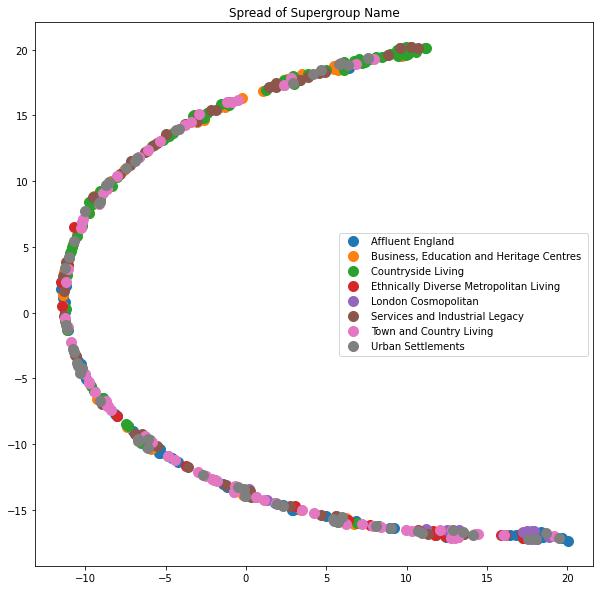

torch.Size([347, 4])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 347 samples in 0.000s...
[t-SNE] Computed neighbors for 347 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 347 / 347
[t-SNE] Mean sigma: 0.017340
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.698982


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.314228


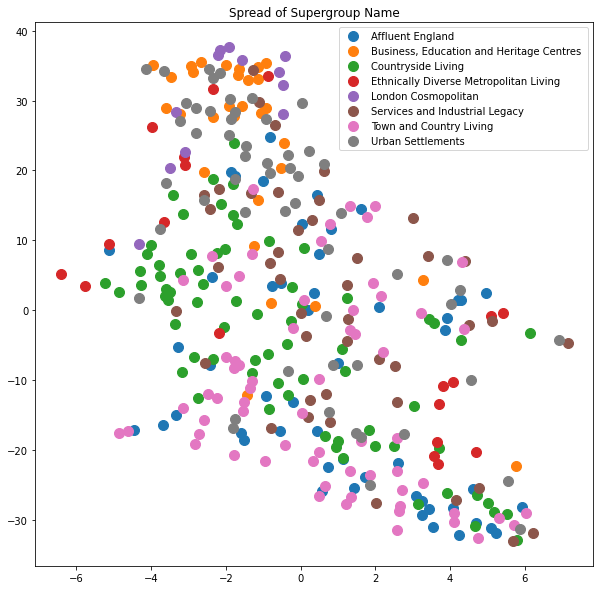

torch.Size([318, 10])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 318 samples in 0.000s...
[t-SNE] Computed neighbors for 318 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 318 / 318
[t-SNE] Mean sigma: 0.040887


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.945492
[t-SNE] KL divergence after 1000 iterations: 1.154983


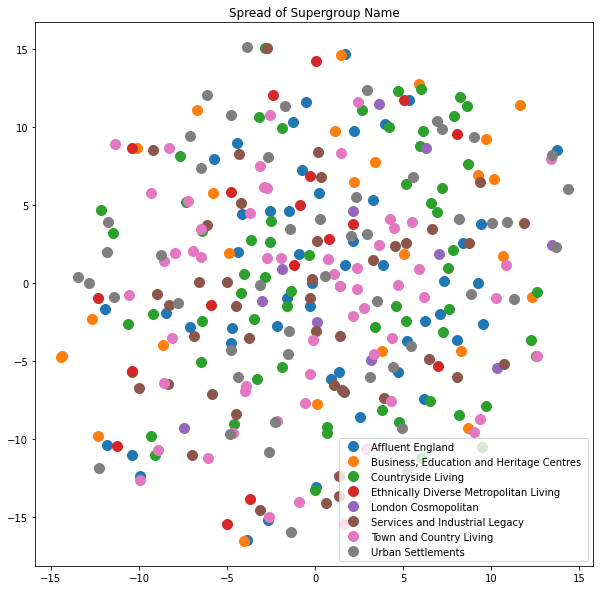

tensor([[ 0.0178, -0.0580,  0.0069,  ..., -0.0231, -0.0755,  0.0661],
        [ 0.0442,  0.0385,  0.0222,  ..., -0.0119, -0.0292, -0.0303],
        [-0.0517, -0.0416,  0.0124,  ..., -0.0051,  0.0206, -0.0736],
        ...,
        [ 0.0009, -0.0275,  0.0323,  ..., -0.0448, -0.0172, -0.0174],
        [ 0.0557, -0.0108,  0.0125,  ...,  0.0180, -0.0092, -0.0053],
        [-0.0568,  0.0460,  0.0377,  ...,  0.0204,  0.0315,  0.0361]])

In [3]:
# Original features
from sklearn.manifold import TSNE

def plot_tsne(tsne, labels, title=''):
    data = pd.DataFrame({'x':tsne[:, 0], 'y':tsne[:, 1], 'label':labels})
    groups = data.groupby('label')
    plt.figure(figsize=(10, 10))
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
    plt.legend()
    plt.title(title)
    plt.show()

def tsne(dataset, category_name, feat_idx=None):    
    cluster_df = load_city_cluster_df(numeric=False)
    labels = []
    features = []
    for data in dataset:
        query = cluster_df.query(f'Name == "{data["place"]}"')
        if (query.empty):
            continue
        else:
            labels.append(query[category_name].values[0])
            if feat_idx is not None:
                features.append(torch.index_select(data['x'], 1, feat_idx))
            else:
                features.append(data['x'])
    avg_feats = [torch.mean(feats, dim=0).detach().cpu() for feats in features]
    avg_feats = torch.stack(avg_feats)
    print(avg_feats.shape)
    tsne = TSNE(learning_rate='auto', verbose=1).fit_transform(avg_feats)

    plot_tsne(tsne, labels, title=f'Spread of {category_name}')
    return avg_feats

# Cluster based on original features
# include_feats = rank_fields # CHANGE THIS
# feat_idx = torch.tensor([feats.index(feat) for feat in include_feats])
# dataset = torch.load(f'{dataset_root}/ssx_dataset.pt')
# tsne(dataset, 'Supergroup Name')
# tsne(dataset, 'Supergroup Name', feat_idx)

# Cluster based on embedded/latent features
single_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
avg_z_dataset = []
for place in single_dataset:
    zs = single_dataset[place]['transductive']['z'][0]
    avg_z_dataset.append({ 'x': zs, 'place': place })
tsne(avg_z_dataset, 'Supergroup Name')

# Standard MLP For Classification

In [ ]:
link_pred_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
link_pred_dataset2a = torch.load(f'{dataset_root}/link_pred_metrics_2_iter1.pt')
link_pred_dataset2b = torch.load(f'{dataset_root}/link_pred_metrics_2_iter2.pt')
link_pred_dataset2 = {**link_pred_dataset2a, **link_pred_dataset2b}
zipfile = f'zip://{dataset_root}/infuse_dist_lyr_2011_clipped.zip'
LA_gdf = gpd.read_file(zipfile)

for place in link_pred_dataset:
    if place not in LA_gdf.geo_label.values:
        print(place)
print('NEXT')
        
for place in LA_gdf.geo_label.values:
    if place not in link_pred_dataset:
        print(place)

### Models

In [20]:
from torch.nn import Linear, Module, Sequential, ModuleList, Conv1d, MaxPool1d
from torch.nn import Identity, ReLU, Sigmoid, Tanh, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GCN2Conv, GraphConv, DynamicEdgeConv, TopKPooling, MLP
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_sort_pool as gsp

activations = {
    'none': (lambda x: x),
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh,
    'logsoft': (lambda x: F.log_softmax(x, dim=-1))
}

gnn_layers = {
    'gcn': GCNConv,
    'gcnii': GCN2Conv,
    'graph': GraphConv
}

# agg_layers = {
#     'max': global_max_pool,
#     'avg': global_mean_pool
# }


class LinearRegression(Module):
    def __init__(self, in_feats, num_classes):
        super(LinearRegression, self).__init__()
        self.layer = Linear(in_feats, num_classes)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = gap(x, batch)
        
        out = self.layer(x)
        return out

class GraphLinear(Linear):
    def forward(self, data, _):
        return super().forward(data)
    
class GraphMLP(Module):
    def __init__(self, in_feats, h_feats, num_layers, num_classes, act=None):
        super(GraphMLP, self).__init__()
        assert num_layers >= 1
        channel_list = [h_feats] * (num_layers - 1)
        channel_list = [in_feats] + channel_list + [num_classes]
        
        layers = []
        for dims in zip(channel_list[:-1], channel_list[1:]):
            layers.append(Linear(*dims))
            layers.append(ReLU())
        self.act = activations[act]
        self.layer = Sequential(*layers)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = gap(x, batch)
        
        out = self.act(self.layer(x))
        return out


class GNN(Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, 
                 act='none', dropout=0.5, type='gcn'):
        super(GNN, self).__init__()
        assert num_layers >= 1
        layer = gnn_layers[type]
        
        self.num_layers = num_layers
        self.lin = Linear(h_feats, num_classes)
        self.dropout = dropout
        self.act = activations[act]
        self.layers = ModuleList()
        channel_list = [h_feats] * num_layers
        channel_list = [in_feats] + channel_list
        for dims in zip(channel_list[:-1], channel_list[1:]):
            self.layers.append(layer(*dims))

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)            
            
        x = gap(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.act(self.lin(x))
        
        return x
    

class TopKGNN(Module):
    def __init__(self, in_feats, h_feats, num_classes, type='graph', act='none'):
        super().__init__()
        gnn_layer = gnn_layers[type]
        
        self.conv1 = gnn_layer(in_feats, h_feats)
        self.pool1 = TopKPooling(h_feats, ratio=0.8)
        self.conv2 = gnn_layer(h_feats, h_feats)
        self.pool2 = TopKPooling(h_feats, ratio=0.8)
        self.conv3 = gnn_layer(h_feats, h_feats)
        self.pool3 = TopKPooling(h_feats, ratio=0.8)

        self.lin1 = torch.nn.Linear(h_feats * 2, h_feats)
        self.lin2 = torch.nn.Linear(h_feats, h_feats // 2)
        self.lin3 = torch.nn.Linear(h_feats // 2, num_classes)
        
        self.act = activations[act]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        # x = self.lin3(x)
        x = self.act(self.lin3(x))
        return x

class DGCNN(torch.nn.Module):
    def __init__(self, in_feats, hidden_channels, num_classes, num_layers,
                 train_dataset, GNN=GCNConv, k=0.6, act='none'):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(in_feats, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, num_classes], dropout=0.5, batch_norm=False)
        self.act = activations[act]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        xs = [x]
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = gsp(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        return self.act(self.mlp(x))


class GNNBetMLP(Module):
    def __init__(self, nhid,dropout):
        super(GNNBetMLP, self).__init__()
        self.dropout = dropout
        self.linear1 = torch.nn.Linear(nhid,2*nhid)
        self.linear2 = torch.nn.Linear(2*nhid,2*nhid)
        self.linear3 = torch.nn.Linear(2*nhid,1)


    def forward(self,input_vec,dropout):

        score_temp = F.relu(self.linear1(input_vec))
        score_temp = F.dropout(score_temp,self.dropout)
        score_temp = F.relu(self.linear2(score_temp))
        score_temp = F.dropout(score_temp,self.dropout)
        score_temp = self.linear3(score_temp)

        return score_temp
    

# Only for single output
class GNNBetFullMLP(GNN):
    def __init__(self, in_feats, h_feats, num_layers, dropout, agg='gcn'):
        super(GNNBetFullMLP, self).__init__(in_feats, h_feats, h_feats, 
                                            num_layers, dropout=dropout, type=agg)
        self.score_layer = GNNBetMLP(h_feats * num_layers, self.dropout)

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, batch = data.x, data.edge_index, data.batch
        embeddings = []
        
        #Layers for aggregation operation
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.normalize(x, p=2, dim=1)
            x_agg = gap(x, batch)
            embeddings.append(x_agg)
            
        
        full_embedding = torch.cat(embeddings, dim=1)
        score = self.score_layer(full_embedding, self.dropout)
        
        return score

## Graph Regression/Classification

In [ ]:
from sklearn.metrics import r2_score

learning_rate = 0.0002
h_feats = 32
target_index = 0
dropout = 0.6
num_node_features, num_classes = get_data_stats(train_loader.dataset, target_index)
num_layers = 3

model = DGCNN(num_node_features, h_feats, num_classes, num_layers, train_loader.dataset)
# model = GNNBetFullMLP(num_node_features, h_feats, num_layers, dropout)
# model = GNN(num_node_features, h_feats, num_classes, num_layers, act='logsoft')
# model = TopKGNN(num_node_features, h_feats, num_classes)
# model = GraphMLP(num_node_features, h_feats, num_layers, num_classes)
# model = LinearRegression(num_node_features, num_classes)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss() if num_classes == 1 else torch.nn.NLLLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        target = data.y.unsqueeze(1).float() if num_classes == 1 else data.y[:,target_index].long()
        loss = criterion(out, target)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)
        if num_classes == 1:
            out = out.squeeze(1).cpu().detach()
            correct += r2_score(data.y.cpu().detach(), out)  # Check correlation against ground-truth.
        else:
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y[:,target_index]).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive average correlation.

num_epochs = 100
print_every = 1
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if (epoch + 1) % print_every == 0:
            start = len(train_losses) - print_every
            mean_train = np.mean(train_losses[start:])
            mean_test = np.mean(test_losses[start:])
            print(f'Epoch: {epoch + 1:03d}, Train: {mean_train:.4f}, Val: {mean_test:.4f}')
    train_losses.append(train_acc)
    test_losses.append(test_acc)

# ..

In [32]:
from torch_geometric.loader import DataLoader 
import torch_geometric.transforms as T

def create_dual_cities_dataset(normalize=True):
    ssx_dual_dataset = torch.load(f'{dataset_root}/ssx_dataset_dual.pt')
    traffic_df = pd.read_csv(f'{dataset_root}/local_authority_traffic.csv')
    traffic_places = traffic_df[traffic_df['year']==2011]['local_authority_name'].values
    ssx_places = [data.place for data in ssx_dual_dataset]
    
    traffic_2011 = traffic_df[traffic_df['year']==2011]
    traffic = traffic_2011[traffic_2011['local_authority_name'].isin(ssx_places)]
    dataset = []
    stat_names = ['cars_and_taxis', 'all_motor_vehicles']
    
    traffic.loc[:,stat_names] = traffic.loc[:,stat_names].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
    for data in ssx_dual_dataset:
        if data.place in traffic_places:
            data.y = torch.tensor([
                traffic[traffic['local_authority_name'] == data.place][stat].values[0] \
                for stat in stat_names
            ])
            dataset.append(data)
    return dataset

def process_dataset(dataset, include_feats=None, split=0.8, batch_size=64, verbose=False):
    # Reduce data.x to only include_feats if desired
    node_attrs = dataset[0].node_attrs
    if include_feats and include_feats != node_attrs:
        feat_idx = torch.tensor([node_attrs.index(feat) for feat in include_feats])
        for data in dataset:
            data.num_nodes = data.x.size(0)
            data.x = torch.index_select(data.x, 1, feat_idx).float() \
                     if len(feat_idx) > 0 else None
    
    transform = T.Compose([
        T.NormalizeFeatures(),
        T.ToDevice(device)
    ])

    # Train-test split
    idx = torch.randperm(len(dataset))
    split_idx = math.floor(split * len(dataset))
    train_idx = idx[:split_idx]
    test_idx = idx[split_idx:]
    train_dataset = [transform(dataset[i]) for i in train_idx]
    test_dataset = [transform(dataset[i]) for i in test_idx]
    if verbose:
        print(f'Number of training graphs: {len(train_dataset)}')
        print(f'Number of test graphs: {len(test_dataset)}')
    
    # Load graphs into dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    if verbose:
        for step, data in enumerate(train_loader):
            print(f'Step {step + 1}:')
            print('=======')
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return train_dataset, test_dataset, train_loader, test_loader


In [33]:
from sklearn.metrics import r2_score

# model = DGCNN(num_node_features, h_feats, num_classes, num_layers, train_loader.dataset)
# model = GNNBetFullMLP(num_node_features, h_feats, num_layers, dropout)
# model = GNN(num_node_features, h_feats, num_classes, num_layers, act='logsoft')
# model = TopKGNN(num_node_features, h_feats, num_classes)
# model = GraphMLP(num_node_features, h_feats, num_layers, num_classes)
# model = LinearRegression(num_node_features, num_classes)
# print(model)

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index, data.batch) # Perform a single forward pass.
        # target = data.y.unsqueeze(1).float() if num_classes == 1 else data.y[:,target_index].long()
        loss = criterion(out.squeeze(), data.y.float())  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(model, loader, criterion):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)
        # if num_classes == 1:
        out = out.squeeze().cpu().detach()
        correct += criterion(data.y.cpu().detach(), out)  # Check correlation against ground-truth.
        # else:
        #     pred = out.argmax(dim=1)  # Use the class with highest probability.
        #     correct += int((pred == data.y[:,target_index]).sum())  # Check against ground-truth labels.
    return correct / len(loader)  # Derive average correlation.

# num_epochs = 100
# print_every = 1
# train_losses = []
# test_losses = []
# for epoch in range(num_epochs):
#     train()
#     train_acc = test(train_loader)
#     test_acc = test(test_loader)
#     if (epoch + 1) % print_every == 0:
#             start = len(train_losses) - print_every
#             mean_train = np.mean(train_losses[start:])
#             mean_test = np.mean(test_losses[start:])
#             print(f'Epoch: {epoch + 1:03d}, Train: {mean_train:.4f}, Val: {mean_test:.4f}')
#     train_losses.append(train_acc)
#     test_losses.append(test_acc)

In [38]:
from models.pool import PoolGNN
from utils.seed import seed_everything
import time

def run(
    dataset,
    data_process_args = {},
    model_args = {
        'model_type': 'gat', 
        'pool_type': 'add', 
        'model_kwargs': {
            'hidden_channels': 10,
            'num_layers': 2
        },
        'pool_kwargs': {}
    },
    seed=42,
    num_iter=5,
    epochs=1000,
    print_every=10,
    lr=0.001,
    schedule_lr=True
):
    """
        Trainer for batched graph train-test split.
        
        Args:
        data_process_args (dict): Optional keywords for data preprocessing/batching
            split, hold_out_edge_ratio, batch_size, include_feats, add_deg_feats
        model_args (dict): Keyword arguments to modify the model including:
            out_channels (int): Latent variable dimension.
                (default: 10)
            model_type (str, optional): Type of gnn layer to use in the encoder.
                (default: 'gat')
            distmult (bool, optional): To set the decoder to DistMult. Defaults 
            to inner product.
                (default: False)
            linear (bool, optional): (default: False)
            variational (bool, optional): (default False)
            + Parameters to pass to torch's BasicGNN models (jk, num_layers, etc.)
    """
    if seed:
        seed_everything(seed)
        
    data_process_args.update({
        'split': 0.8,
        'batch_size': 1,
        'verbose': False
    })
    if type(dataset) is tuple:
        # Assume already processed via process_dataset
        train_dataset, test_dataset, train_loader, test_loader = dataset
    else:
        train_dataset, test_dataset, train_loader, test_loader = process_dataset(dataset, **data_process_args)
    in_channels = train_dataset[0].num_node_features
    out_channels = len(train_dataset[0].y)
    model_args['model_kwargs']['in_channels'] = in_channels
    model_args['model_kwargs']['out_channels'] = out_channels
    criterion = torch.nn.MSELoss()
    
    # Logging
    results = []
    models = []
    
    for i in range(1, num_iter + 1):
        print(f'Running iteration {i} of expt {data_process_args}, {model_args}')
        start_time = time.time()
        epoch_start_time = start_time
        
        # Initialize a new model every iteration
        model = PoolGNN(**model_args)
        model = model.to(device)
        model.data_process_args = data_process_args
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        if schedule_lr:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, min_lr=0.00001)
        
        result_dict = {'Train Loss': [], 'Test Loss': []}
        for epoch in range(1, epochs + 1):
            loss = train(model, train_loader, optimizer, criterion)
            # Transductive metrics
            val_loss = test(model, test_dataset, criterion)
            
            # Logging
            result_dict['Train Loss'].append(loss)
            result_dict['Test Loss'].append(val_loss)
             
            if schedule_lr:
                # Reduce LR if the target metric decreased
                scheduler.step(val_loss)
                
            if epoch % print_every == 0:
                sec_per_epoch = (time.time() - epoch_start_time) / print_every
                epoch_start_time = time.time()
                epoch_feed = (f'Epoch {epoch:03d} ({sec_per_epoch:.2f}s/epoch): '
                f'Train Loss: {loss:.4f}, Test Loss: {val_loss:.4f}')
                print(epoch_feed)
        
        result_df = pd.DataFrame.from_records([{
            key: result_dict[key][-1]
            for key in result_dict
            if len(result_dict[key]) > 0
        }])
        
        sec_per_epoch = (time.time() - start_time) / epochs
        print(f'Iteration {i} done, averaged {sec_per_epoch:.3f}s per epoch. Results:')
        display(result_df)
        # roc_curve, pr_curve = test_curve(model, )
        # result_dict['roc_curve'] = roc_curve
        # result_dict['pr_curve'] = pr_curve
        result_dict['sec_per_epoch'] = sec_per_epoch
        result_dict['model_details'] = model.__repr__()
        results.append(result_dict)
        models.append(model)
    
    return models, results

In [1]:
for model_type in ['gat', 'gcn', 'gain']:
    data_process_args = {
        'include_feats': ['choice2kmrank', 'choice10kmrank','integration10kmrank', 'integration2kmrank']
    }

    model_args = {
        'model_type': model_type,
        'pool_type': 'add', 
        'model_kwargs': {
            'hidden_channels': 10,
            'num_layers': 2
        },
        'pool_kwargs': {}
    }
    dataset = create_dual_cities_dataset()
    run(dataset, 
        data_process_args, 
        model_args=model_args, 
        num_iter=3)

NameError: name 'create_dual_cities_dataset' is not defined